# Gaussian Mixture Model vs. KMeans

<hr>

## 0. Introduction

### 0.1 Task Description

**Clustering** is abour grouping similar objects together. It is a type of **unsupervised learning**. Unsupervised learning is the generic application of machine learning to bunch data together based on criteria of similarities. Unsupervised learning algorithm will work to partition data into smaller group of similar objects while trying to maximize the difference between other groups.

KMeans and Gaussian Mixture Models are example of clustering algorithms. The goal of this following document is to compare the application of the KMeans and GMM algorithms on the Fashion-MNIST dataset. Afterward, we will explore the impacts of changing the GMM's parameters.

### 0.2 Notebook Content

- **0. Introduction**
    - Task Description
    - Table of Content
    - Importing Modules
    
    
- **1. Importing the Dataset**
    - Importing
    - Data Pre-Processing


- **2. Implementation of KMeans**
    - Simple Implementation From Scratch
    - Implementation using SciKit-Learn
    - Observations
    
    
- **3. Implementation of GMM**
    - Simple Implementation From Scratch
    - Implementation using SciKit-Learn
    - Observations
    
    
- **4. Comparing the best results of both KMeans and GMM**
    - 5.1. Comparisons
    - 5.2. Other Explorations
    

- **5. Exploring the parameters of GMM, i.e. Implementing Efficient Greedy Learning**


- **6. References**

### 0.3 Importing Modules

In [1]:
from keras.datasets import fashion_mnist

from itertools import cycle
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn import decomposition
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 1. Importing the dataset: Fashion-MNIST

### 1.1. Importing

Our first step is to import our dataset: [Fashion-MNIST](https://keras.io/api/datasets/fashion_mnist/).

In [2]:
(x_train_origin, y_train), (x_test_origin, y_test) = fashion_mnist.load_data()

labelNames = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print(f"Shape of x_train_origin: {x_train_origin.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test_origin: {x_test_origin.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train_origin: (60000, 28, 28)
Shape of y_train: (60000,)
Shape of x_test_origin: (10000, 28, 28)
Shape of y_test: (10000,)


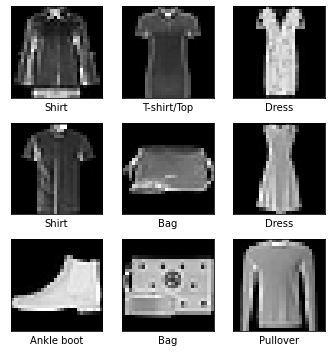

In [3]:
# Sample images

length = 3
plt.figure(figsize=(5, 5)) 
for i in range(length * length):
    temp = rd.randint(0, len(x_train_origin)+1)
    image = x_train_origin[temp] 
    plt.subplot(length, length, i+1)       
    plt.imshow(image, cmap='gray')  
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labelNames[y_train[temp]])
    plt.tight_layout()   
plt.show()

### 1.2. Data Preprocessing

Data Pre-Processing is an important first step towards machine learning. Below, we will go through three different pre-processing steps.

**Normalization**: Each item in the dataset is a grayscale picture (i.e. 1 channel instead of 3 for RGB) where each pixel is a value lying between $0$ and $255$. We need to rescale each image to the [0,1] range, i.e., normalize our images. This rescaling is done by dividing each pixel value by 255.

In [4]:
# Before
print(f"One pixel before normalization: {x_train_origin[0][5][15]}")

# Normalization
x_train = x_train_origin / 255.
x_test = x_test_origin / 255.

# After
print(f"One pixel after normalization: {x_train[0][5][15]}")

One pixel before normalization: 204
One pixel after normalization: 0.8


**Flattening**: Since each image is a 2d picture of 28 pixels by 28 pixels, we need to reshape our data so it can be fed in a model. To do so, we reshape our image into a single dimension of size 28\*28, i.e. 784.

In [5]:
x_train = x_train.reshape(len(x_train), 784)
x_test = x_test.reshape(len(x_test), 784)

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)


**Feature Extraction**: PCA is used for dimensionality reduction to visualize high dimensional data. We do dimensionality reduction to convert the high dimensional dataset into smaller-dimensional one.

The goal here is to reduce the dimensionality of our dataset to accelerate our training. To do so, we compute the cumulative explained variance with a number of components from 0 to 784.

In [6]:
pca = decomposition.PCA()

x_train = StandardScaler().fit_transform(x_train)
x_test = StandardScaler().fit_transform(x_test)

pca.n_components = 784
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

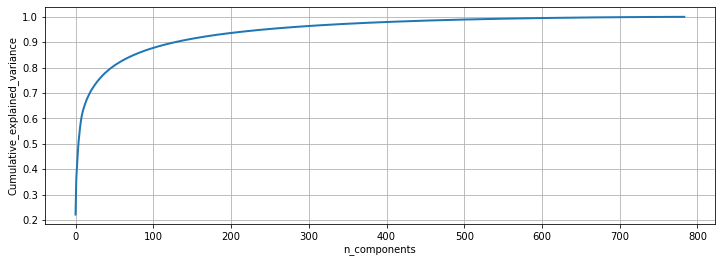

In [7]:
# Plot the PCA spectrum
plt.figure(1, figsize=(12, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis("tight")
plt.grid()
plt.xlabel("n_components")
plt.ylabel("Cumulative_explained_variance")
plt.show()

We find that 90%+ of the variance is explained once we reach 100+ components. As such we settled on a dimensionality reduction to 121 components, which provides us an easy 11\*11 representation.

In [8]:
pca = decomposition.PCA(n_components=121)
x_train_processed = pca.fit_transform(x_train)
x_test_processed = pca.fit_transform(x_test)

print(f"Shape of x_train_processed: {x_train_processed.shape}")
print(f"Shape of x_test_processed: {x_test_processed.shape}")

Shape of x_train_processed: (60000, 121)
Shape of x_test_processed: (10000, 121)


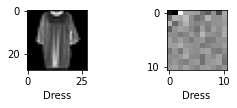

In [9]:
for i in rd.sample(range(60000),1):
    i1 = x_train_origin[i] 
    i2 = x_train_processed[i].reshape(11,11)
    plt.subplot(length, length, 1)       
    plt.imshow(i1, cmap='gray')  
    plt.xlabel(labelNames[y_train[i]])  
    plt.subplot(length, length, 2)       
    plt.imshow(i2, cmap='gray')  
    plt.xlabel(labelNames[y_train[i]])
    plt.tight_layout()   
    plt.show()

## 3. Implementation of KMeans

KMeans is an **unsupervised clustering algorithm** that tries to cluster the elements of a given dataset into a *k* number of clusters. It proceeds as follow:

```
1. Selects k random points from the dataset as starting cluster centers
2. For all data point in the dataset:
    2.1 calculates the distance (such as the euclidian distance (1)) between the point and the clusters
    2.2 assigns the point to the closest center (2)
3. Update each cluster center by taking the average of the points within the cluster
4. Repeat steps 2 and 3 until convergence, i.e., when the centers do not change
```
$$given\,\,x_i \in \mathbb{R}^m\,\,\forall i, k \in [1, ..., n]$$

$$d(x_i,center_k)=\sqrt{\underset{j=1}{\overset{m}{\sum}}(x_{i,j}-center_{k,j})^2}\,\,\forall i, k \in [1, ..., n] \quad (1)$$

$$cluster(x_i) = argmin\,\,d(x_i,center_k)\,\,\forall i, k \in [1, ..., n] \quad (2)$$

### 3.1. Simple Implementation From Scratch

First of all, let's build our own KNN to see how it works. Using the ``make_blobs`` function from the SciKit-Learn library we implement a KMeans using euclidian distance metrics.

In [10]:
def generate_dataset(number_of_points):
    """
    Generates a dataset of 2d coordinates (x, y), with x and y random values between 0 and 99.
    The set is generated with a random number of centers between 2 and 9.
    """
    X, _ = make_blobs(n_samples=number_of_points, 
                      centers=rd.randint(2,10), 
                      n_features=2, 
                      random_state=0)
    return X

def compare_dict(dict1, dict2):
    """
    Checks if two dictionary are identical.
    """
    for key in dict1.keys():
        if not np.array_equal(dict1[key], dict2[key]): return False
    return True

def euclidian_distance(p1, p2):
    """
    Calculates the euclidian distance between two points in the R² space.
    """
    distance = 0
    for idx, item in enumerate(p1): 
        distance += (item - p2[idx]) ** 2
    return math.sqrt(distance)

In [11]:
class k_means():
    def __init__(self, nb_of_data_points, k=2):
        """
        Initializes the k_means class.
        """
        self.data = generate_dataset(nb_of_data_points)
        self.k = k
        self.iterated = 0
        self.colors = cycle(["g","r","b","c","m","y"])
        
        # Generates an empty dictionary to store each step's centroids
        self.model_centroids = {}
        
        # Generates an empty dictionary to store each step's classification
        self.model_classifications = {}
    
    
    def fit(self, max_iterations=100):
        """
        Fits the model.
        """
        self.iterated = 0
        
        # Select the initial k centroids
        centroids = rd.sample(list(self.data), 2)
        
        # Iterates to fit the model
        for iteration in range(max_iterations):
            print(f"Epoch {iteration}")
            
            # Generates an empty dictionary to store the step's classification
            step_classification = {}
            for k in range(self.k): step_classification[k] = []
            
            # Calculates the euclidian distance between each data points and each centroids
            # Records the points in the classification corresponding to its nearest centroid
            for point in self.data:
                distances = list(map(lambda x: euclidian_distance(point, x), centroids))
                argmin = min(range(len(distances)), key=distances.__getitem__)
                step_classification[argmin].append(point)
            
            # Records the state of the model after the iteration
            self.model_centroids[iteration] = centroids
            self.model_classifications[iteration] = step_classification
            
            # If no change has been identified between this iteration and the last, the model will stop.
            if len(self.model_classifications)>1:
                if compare_dict(self.model_classifications[iteration],
                                self.model_classifications[iteration-1]):
                    self.iterated = iteration
                    print(f"No significant change has been achieved during epoch {self.iterated}. "+\
                          "Model is considered fitted.")
                    break
            
            # Updates the centroids
            centroids = []
            for classification in step_classification.values():
                if classification == []: centroids.append(np.zeros(3))
                else: centroids.append(np.mean(classification, axis=0))
       
    
    def plot_data(self):
        """
        Plots the distribution of the data
        """
        # Declares the plot
        plt.figure(figsize=(6,6))

        # Plots the data without colors if the dataset was not iterated over.
        if self.model_centroids == {} or self.iterated == 0:
            plt.scatter(self.data[:,0],self.data[:,1])

        else:
            # Plots the centroids first
            for centroid in self.model_centroids[self.iterated]:
                plt.scatter(centroid[0], centroid[1], 
                            marker="o", color="k", s=50, linewidths=5)

            # plots the data points
            for classification in self.model_classifications[self.iterated].values():
                color = next(self.colors)
                for feature in classification:
                    plt.scatter(feature[0], feature[1], 
                                marker='x', color=color, s=20, linewidths=2)
        plt.show()

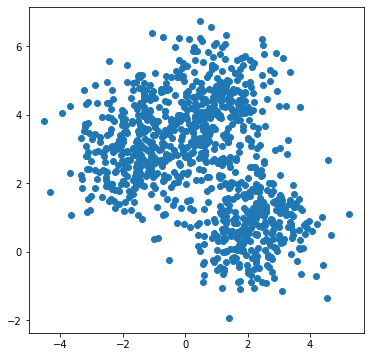

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
No significant change has been achieved during epoch 8. Model is considered fitted.


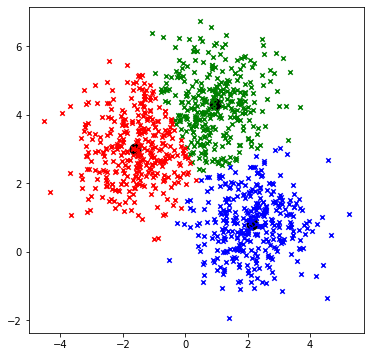

In [12]:
model = k_means(1000, 3)
model.plot_data()
model.fit()
model.plot_data()

### 3.2. Implementation using SciKit-Learn

Now that we know how it works, we can apply the KNN model offered by the SciKit-Learn library onto the Fashion MNIST dataset.

In [13]:
n_clusters = 10 # for the number of classes in Fashion-MNIST
init = "k-means++" # choose n_clusters observations (rows) at random from data for the initial centroids.
n_init=50
max_iter = 100
verbose = 0
algorithm = "elkan" # “elkan” is more efficient on data with well-defined clusters

In [ ]:
model = KMeans(n_clusters=n_clusters, 
               init=init,
               n_init=n_init,
               max_iter=max_iter, 
               verbose=verbose, 
               algorithm=algorithm, 
               random_state=0).fit(x_train_processed)

In [ ]:
label_predictions = model.predict(x_test_processed)

In [ ]:
print(homogeneity_score(y_test, label_predictions))

### 3.3. Observations

The two cells below visualizes the repartition of items between the ten buckets created by the KMeans model above.

In [ ]:
label_number = 10

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(label_number)]
for i, label in enumerate(label_predictions):
    for n in range(label_number):
        if label == n: cluster_index[n].append(i)
        else: continue

for j, _ in enumerate(labelNames):
    plt.figure(figsize=(6,6));
    clust = j #enter label number to visualise T-Shirt/Top
    num = 10
    for i in range(1,4):
        plt.subplot(3, 3, i) #(Number of rows, Number of column per row, item number)
        plt.imshow(x_test_origin[cluster_index[clust][i+20]], cmap = plt.cm.binary);

plt.show()

In [ ]:
clusters={}
for i in range(10):
    clusters[i]=[0]*10

for index, item in enumerate(label_predictions):
    clusters[item][y_test[index]] += 1

for i in range(len(clusters)):
    fig = plt.figure(figsize=(10,3))
    plt.bar(labelNames, clusters[i], color="purple", width=0.4)
    plt.title(f"Amount of items of a specific label assigned to cluster {i}")
    plt.show()

In [ ]:
pca = decomposition.PCA(n_components = 3)
x_test_visualization = StandardScaler().fit_transform(x_test_processed)
x_test_visualization = pca.fit_transform(x_test_visualization)

In [ ]:
colors = ["blue","red","green","pink","purple","cyan","yellow","orange","black","brown"]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for index, item in enumerate(x_test_visualization[:200]):
    ax.scatter(item[0], item[1], item[2], marker="x", color = colors[label_predictions[index]])

plt.show()

<hr> 
<span style="color:green">The above visualizations highlight a few key behaviors:
    
> 1. KMeans is **able to distinguish bags** (clusters 1 and 5), **ankle boots** (cluster 0 and 2), **sandals** and **sneakers** (cluster 4 and 8) from the rest of the dataset
>
> 2. KMeans **struggles identifying trousers from dresses** (cluster 3)
>
> 3. KMeans **struggles identifying all top clothes from each other** (clusters 6, 7, and 9(

We obtained a **homogeneity metric of c. 0.49**. As per sklearn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html): "clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class." A score of 1 implies a perfect labeling with a score of 0 being the minimum.

## 4. Implementation of GMM

Gaussian Mixture Models, or GMM, are a type of machine learning algorithms that aim at extracting normally distributed subpopulations from an overall population. Like KMeans, GMM are a type of unsupervised machine learning.

A GMM is parametrized by two types of values: the **mixture component weights**, and the **component means and variances**.

Given $k$ the number of component $C_k$ of a GMM, each component has a mean $\mu_k$ and a variance $\sigma^2_k$ (for the univariate case, otherwise $\mu$ and $\sigma$ are vectors). The mixture component wieghts are defined as $\phi_k$ for a component $C_k$, with the constraint that $\overset{K}{\underset{i=1}{\sum}}\phi_i=1$ so that the total proability distribution normalizes to 1.

#### One-Dimensional Model

$$p(x) = \underset{i=1}{\overset{K}{\sum}}\phi_i.\mathcal{N}(x|\mu_i, \sigma^2_i)$$

$$\mathcal{N}(x|\mu_i, \sigma^2_i) = \frac{1}{\sigma_i.\sqrt{2.\pi}}.exp(\frac{-(x-\mu_i)^2}{2.\sigma_i^2})$$

$$\underset{i=1}{\overset{K}{\sum}}\phi_i=1$$

#### Multi-Dimensional Model

$$p(x) = \underset{i=1}{\overset{K}{\sum}}\phi_i.\mathcal{N}(\overset{\rightarrow}{x}|\overset{\rightarrow}{\mu_i}, \sum_i)$$

$$\mathcal{N}(\overset{\rightarrow}{x}|\overset{\rightarrow}{\mu_i}, \sum_i) = \frac{1}{\sqrt{(2.\pi)^K.|\sum_i|}}.exp(-\frac{1}{2}.(\overset{\rightarrow}{x}-\overset{\rightarrow}{\mu_i})^T).\sum_i^{-1}.(\overset{\rightarrow}{x}-\overset{\rightarrow}{\mu_i}))$$

$$\underset{i=1}{\overset{K}{\sum}}\phi_i=1$$

Expectation Maximization or EM is the most common technique to estimate the mixture model's parameter when the number of components $k$ is known. EM is a numerical technique for maximum likelihood estimation. EM is an iterative algorithm and is guaranteed to approach a local maximum or saddle point.

#### Expectation Maximization

EM proceeds as follow:

```
1. Random assignment of k samples without replacement from the dataset to k component mean estimates
2. All component variance estimates (1)
3. Set all component distribution prior estimates to the uniform distribution (2)
4. E(xpectation)-Step: Calculation of the probability that each data point x is generated by a component C (3)
5. M(aximization)-Step: Maximization of the expectations calculated in the E step with respect to the model parameters. The model parameters are updated (4)
6. The steps 1 and 2 are repeated until convergence
```

$$\sigma^2_k = \underset{i=1}{\overset{N}{\sum}}(x_i - \bar{x})^2 \quad (1)$$

$$\phi_i = \frac{1}{K} \quad (2)$$

$$\forall i,k \quad \hat{\gamma}_{i,k}=\frac{\hat{\phi}_k.\mathcal{N}(x_i|\hat{\mu}_k, \hat{\sigma}^2_k)}{\underset{j=1}{\overset{K}{\sum}}\hat{\phi}_j.\mathcal{N}(x_i|\hat{\mu}_j, \hat{\sigma}^2_j)}=p(C_k|x_i,\hat{\phi},\hat{\mu},\hat{\sigma}^2) \quad (3)$$

$$\forall k \quad \hat{\phi}_k = \underset{i=1}{\overset{N}{\sum}}\frac{\hat{\gamma}_{i,k}}{N} \quad (4.1)$$

$$\forall k \quad \hat{\mu}_k=\frac{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}.x_i}{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}} \quad (4.2)$$

$$\forall k \quad \hat{\sigma}^2_k=\frac{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}.(x_i-\hat{\mu}_k)^2}{\underset{i=1}{\overset{N}{\sum}}\hat{\gamma}_{i,k}} \quad (4.3)$$

### 4.1. Simple Implementation From Scratch

First of all, let's build our own GMM to see how it works. Using the ``make_blobs`` function from the SciKit-Learn library we implement a GMM.

In [ ]:
class GMM():
    def __init__(self, nb_of_data_points, k=2):
        """
        Initializes the GMM class.
        """
        self.data = generate_dataset(nb_of_data_points)
        self.k = k
        self.colors = ["g","r","b","c","m","y"]
        self.phi = [1/self.k for _ in range(self.k)]
        self.cluster_names = list(range(10))
        self.clusters = []
    
    def multivariate_normal(self, X, mean_vector, covariance_matrix):
        """
        Formula of the multivariate normal distribution.
        """
        first_element = ((2*np.pi)**len(X) * np.linalg.det(covariance_matrix))**(-1/2)
        #print((X-mean_vector).shape, np.linalg.inv(covariance_matrix).shape, (X-mean_vector).shape)
        exponential = np.exp(-1/2*np.dot(np.dot((X-mean_vector), np.linalg.inv(covariance_matrix)).T, (X-mean_vector)))
        return first_element * exponential    
    
    def fit(self, max_iterations=100):
        """
        Fits the model.
        """
        # Splits the data in k subsets
        X = np.array_split(self.data, self.k)
        
        #initializes the computation of the mean vector and the covariance matric
        self.mean_vector = [np.mean(x, axis=0) for x in X]
        self.covariance_matrices = [np.cov(x.T) for x in X]
        del X
        
        for iteration in range(max_iterations):
            if iteration %10 == 0: print(f"Epoch {iteration}")
            
            # E-Step
            # Calculates the gammas
            self.p = np.zeros((len(self.data), self.k)) #, dtype=object)
            # Calculatges the phi matrix
            for n in range(len(self.data)):
                for k in range(self.k):
                    self.p[n][k] = self.phi[k] * self.multivariate_normal(self.data[n], 
                                                                   self.mean_vector[k],
                                                                   self.covariance_matrices[k])
                    self.p[n][k] /= sum([
                        self.phi[j]*self.multivariate_normal(self.data[n], 
                                                            self.mean_vector[j], 
                                                            self.covariance_matrices[j]) 
                        for j in range(self.k)
                    ])
            N = np.sum(self.p, axis = 0)            
            # M-Step
            # initializes the mean vector as a zero vector
            self.mean_vector = np.zeros((self.k, len(self.data[0])))
            # Updating the mean vector
            for k in range(self.k):
                for n in range(len(self.data)):
                    self.mean_vector[k] += self.p[n][k] * self.data[n]
            self.mean_vector = [1/N[k]*self.mean_vector[k] for k in range(self.k)]
            # Initializes the list of the covariance matrices
            self.covariance_matrixes = [np.zeros((len(self.data[0]), len(self.data[0]))) for k in range(self.k)]
            # Updates the covariance matrices
            for k in range(self.k):
                self.covariance_matrices[k] = np.cov(self.data.T, aweights=(self.p[:,k]), ddof=0)
            self.covariance_matrices = [1/N[k]*self.covariance_matrices[k] for k in range(self.k)]
            # update the phi list
            self.phi = [N[k]/len(self.data) for k in range(self.k)]     
    
    def predict(self):
        """
        Predicts the data.
        """
        probabilities = []
        for n in range(len(self.data)):
            probabilities.append([self.multivariate_normal(self.data[n], 
                                                           self.mean_vector[k], 
                                                           self.covariance_matrices[k]) 
                                  for k in range(self.k)])
        self.clusters = []
        for prob in probabilities:
            self.clusters.append(self.cluster_names[prob.index(max(prob))])
        return self.clusters
        
    def plot_data(self):
        """
        Plots the distribution of the data
        """
        # Declares the plot
        plt.figure(figsize=(6,6))

        # Plots the data without colors if the dataset was not iterated over.
        if self.clusters == []:
            plt.scatter(self.data[:,0],self.data[:,1])
        else:
            for index, datum in enumerate(self.data):
                plt.scatter(datum[0], datum[1], marker='x', color=self.colors[self.clusters[index]], s=20, linewidths=2)
        plt.show()

In [ ]:
model = GMM(100, 3)
model.plot_data()
model.fit()
model.predict()
model.plot_data()

### 4.2. Implementation using SciKit-Learn

In [ ]:
n_components = 10 # for the number of classes in Fashion-MNIST
n_init=20
max_iter = 100
verbose = 0

In [ ]:
model = GaussianMixture(n_components=n_components, 
                        n_init=n_init,
                        max_iter=max_iter, 
                        verbose=verbose,
                        random_state=0).fit(x_train_processed)

In [ ]:
label_predictions = model.predict(x_test_processed)

In [ ]:
print(homogeneity_score(y_test, label_predictions))

### 3.3. Observations

The two cells below visualizes the repartition of items between the ten buckets created by the KMeans model above.

In [ ]:
label_number = 10

#2D matrix  for an array of indexes of the given label
cluster_index= [[] for i in range(label_number)]
for i, label in enumerate(label_predictions):
    for n in range(label_number):
        if label == n: cluster_index[n].append(i)
        else: continue

for j, _ in enumerate(labelNames):
    plt.figure(figsize=(6,6));
    clust = j #enter label number to visualise T-Shirt/Top
    num = 10
    for i in range(1,4):
        plt.subplot(3, 3, i) #(Number of rows, Number of column per row, item number)
        plt.imshow(x_test_origin[cluster_index[clust][i+20]], cmap = plt.cm.binary);

plt.show()

In [ ]:
clusters={}
for i in range(10):
    clusters[i]=[0]*10

for index, item in enumerate(label_predictions):
    clusters[item][y_test[index]] += 1

for i in range(len(clusters)):
    fig = plt.figure(figsize=(10,3))
    plt.bar(labelNames, clusters[i], color="purple", width=0.4)
    plt.title(f"Amount of items of a specific label assigned to cluster {i}")
    plt.show()

In [ ]:
pca = decomposition.PCA(n_components = 3)
x_test_visualization = StandardScaler().fit_transform(x_test_processed)
x_test_visualization = pca.fit_transform(x_test_visualization)

In [ ]:
colors = ["blue","red","green","pink","purple","cyan","yellow","orange","black","brown"]

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
for index, item in enumerate(x_test_visualization[:200]):
    ax.scatter(item[0], item[1], item[2], marker="x", color = colors[label_predictions[index]])

plt.show()

<hr> 
<span style="color:green">The above visualizations highlight a few key behaviors:
    
> 1. KMeans is **able to distinguish bags** (clusters 1 and 5), **ankle boots** (cluster 0 and 2), **sandals** and **sneakers** (cluster 4 and 8) from the rest of the dataset
>
> 2. KMeans **struggles identifying trousers from dresses** (cluster 3)
>
> 3. KMeans **struggles identifying all top clothes from each other** (clusters 6, 7, and 9(

We obtained a **homogeneity metric of c. 0.49**. As per sklearn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html): "clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class." A score of 1 implies a perfect labeling with a score of 0 being the minimum.

## 5. Comparing results of both KMeans and GMM

### 5.1. Comparisons

### 5.2. Other Explorations

## 6. Exploring the parameters of GMM, i.e. Implementing Efficient Greedy Learning

Based on ``Verbeek, Jakob & Vlassis, Nikos & Krose, B.. (2003). Efficient Greedy Learning of Gaussian Mixture Models. Neural computation. 15. 469-85. 10.1162/089976603762553004``.

## 7. References used for this exercise

- https://www.researchgate.net/publication/10896453_Efficient_Greedy_Learning_of_Gaussian_Mixture_Models
- https://www.kaggle.com/c/ttic-31020-hw5-fmnist-gmm/leaderboard (leaderboard for GMM classification of Fashion-MNIST)
- https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://brilliant.org/wiki/gaussian-mixture-model/
- https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566